In [1]:
from fastai.vision.all import *
import PIL
path =  Path('/home/jupyter/VLP')


In [2]:
df  = pd.read_csv(path/'captioned.csv')

In [3]:
HATE_PATH = Path('/home/jupyter/mmf_data/datasets/hateful_memes/defaults/')
def id_to_img_path(id):
    id = f'{int(id):05d}'
    return str(HATE_PATH/f'images/img/{id}.png')

In [4]:
df[:9000]

,id,img,label,text,caption,is_valid,tex_cap
0,42953,img/42953.png,0.0,its their character not their color that matters,A man in a black shirt is looking at the camera .,False,A man in a black shirt is looking at the camera . <meme> its their character not their color that matters
1,23058,img/23058.png,0.0,don't be afraid to love again everyone is not like your ex,A man in a suit is talking to a woman in a white shirt .,False,A man in a suit is talking to a woman in a white shirt . <meme> don't be afraid to love again everyone is not like your ex
2,13894,img/13894.png,0.0,putting bows on your pet,A cat with a red bow tied around its neck sits next to a pillow .,False,A cat with a red bow tied around its neck sits next to a pillow . <meme> putting bows on your pet
3,37408,img/37408.png,0.0,i love everything and everybody! except for squirrels i hate squirrels,A black dog is looking at the camera .,False,A black dog is looking at the camera . <meme> i love everything and everybody! except for squirrels i hate squirrels
4,82403,img/82403.png,0.0,"everybody loves chocolate chip cookies, even hitler",A man in a suit is talking .,False,"A man in a suit is talking . <meme> everybody loves chocolate chip cookies, even hitler"
...,...,...,...,...,...,...,...
8995,83675,img/83675.png,0.0,i'm gonna be like phelps one day,A swimmer wearing a red helmet is swimming .,True,A swimmer wearing a red helmet is swimming . <meme> i'm gonna be like phelps one day
8996,37198,img/37198.png,0.0,when you're so relaxed you can feel yourself go to the next level,A man is lying on the grass .,True,A man is lying on the grass . <meme> when you're so relaxed you can feel yourself go to the next level
8997,48670,img/48670.png,0.0,look at this sandwich maker club i found on wish on clearance,there is a bread on a grill .,True,there is a bread on a grill . <meme> look at this sandwich maker club i found on wish on clearance
8998,9863,img/09863.png,0.0,diverse group of women,A group of women pose for a picture .,True,A group of women pose for a picture . <meme> diverse group of women


In [5]:
dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                           get_x=ColReader('img', pref=f'{HATE_PATH}/images/'),
                           get_y=ColReader('label'),
                           splitter=ColSplitter('is_valid'),
                           item_tfms=RandomResizedCrop(128),
                           batch_tfms=aug_transforms())
dls = ImageDataLoaders.from_dblock(dblock,df[:9000], path)

In [6]:
batch = dls.train.one_batch()

In [7]:
learn = cnn_learner(dls, resnet34, metrics=[accuracy, RocAucBinary()])

In [9]:
learn.fine_tune(1)

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,1.031029,0.875782,0.530000,0.521680,01:19


epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.743798,0.754616,0.510000,0.520480,00:25


In [ ]:
#learn.save('res34')


In [10]:
interp = ClassificationInterpretation.from_learner(learn)
interp.print_classification_report()

              precision    recall  f1-score   support

         0.0       0.51      0.74      0.60       250
         1.0       0.52      0.28      0.37       250

    accuracy                           0.51       500
   macro avg       0.51      0.51      0.48       500
weighted avg       0.51      0.51      0.48       500



In [11]:
inputs, preds, targs, decoded, losses = learn.get_preds(dl=dls.valid, with_input=True, with_loss=True, with_decoded=True, act=None)

In [12]:
preds.shape, targs.shape, decoded.shape, losses.shape


(torch.Size([500, 2]), torch.Size([500]), torch.Size([500]), torch.Size([500]))

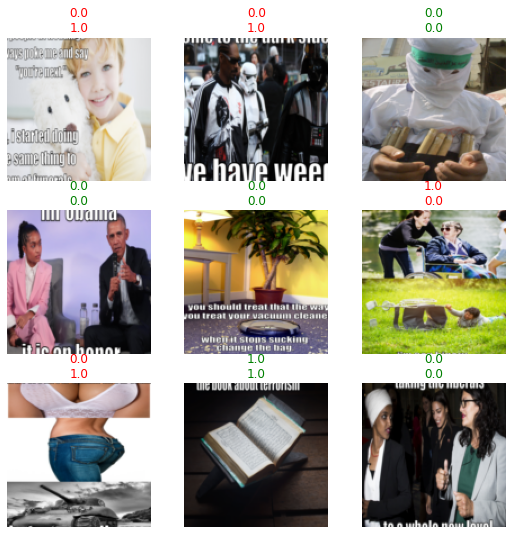

In [17]:
learn.show_results()

In [154]:
def gen_submit(learn, fname):
    test_df = pd.read_json(path/'test.jsonl', lines=True)
    test_dl = learn.dls.test_dl(test_df)
    preds = learn.get_preds(dl=test_dl)[0]
    probs= preds[:,1]
    submit_df = pd.DataFrame()
    submit_df['id'] = test_df['id']
    submit_df['proba'] = probs
    submit_df['label'] = indcs
    submit_df = submit_df.set_index('id')
    submit_df.to_csv(fname, header=True)

In [155]:
gen_submit(learn, path/'attempt1.csv')

In [148]:
s

In [149]:
submit_df

,proba,label
id,,
16395,0.769978,0
37405,0.599912,0
94180,0.520897,0
54321,0.832810,0
97015,0.543728,1
...,...,...
3869,0.878503,0
23817,0.899243,0
56280,0.724428,0
